### Settings

In [18]:
sc_file = './PTB_DATA/Run01_160525.txt'
count_file = './PTB_DATA/2016_MAY_25/2016_MAY_25_3.MSa'

In [19]:
import numpy as np
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (10.0, 7.0)

In [20]:
def convert_sc_time(s):
    '''
    Take a string in the format of SC program and convert it to something sensible.
    Example string: "b'25.05.2016 13:30:56"
    '''
    # Cut off b' part
    s = s[2:]
    day = int(s[0:2])
    month = int(s[3:5])
    year = int(s[6:10])
    hour = int(s[11:13])
    minute = int(s[14:16])
    second = int(s[17:19])
    return datetime.datetime(year,month,day,hour,minute,second)

In [21]:
def convert_count_time(date,time):
    '''
    Take string in format of counter and convert it.
    '25-MAY-2016', '15:44:54'
    '''
    day = int(date[0:2])
    month_str = (date[3:6])
    if month_str == 'MAY':
        month = 5
    else:
        raise ValueError("What? How dare you operate outside of May?!")
    year = int(date[-4:])
    hour = int(time[0:2])
    minute = int(time[3:5])
    second = int(time[6:8])
    return datetime.datetime(year,month,day,hour,minute,second)

In [22]:
def append_to_array(array,column,name):
    '''
    Append a column to a numpy array.
    DISCLAIMER this will probably be VERY slow for large arrays, because the code is ugly... 
    If you know a better way, PLEASE tell me!
    '''
    # This gives you a // list // of dtypes
    dt_old = array.dtype.base.descr
    # Detect current type and 
    dtype = tuple((name,column.dtype))
    
    # Now, we construct the dtype list for the NEW array
    # Lord knows why but we have to do it THIS way...
    dt_new = []
    for tup in dt_old:
        dt_new.append(tup)
    dt_new.append(dtype)
    array_new = np.zeros(len(array),dtype = dt_new)
    
    # After that we set the fields. 
    # Again... One by one...
    # TODO can this be faster?
    # Set the old fields
    for field_name in array.dtype.names:
        array_new[field_name] = array[field_name]
    # Set the new field
    array_new[dtype[0]] = column
    
    # Done!
    return array_new

In [23]:
# Load SC data
dt = np.dtype([('date-time',np.str_,21),
               ('v', np.float64),
               ('v_set', np.float64),
               ('i', np.float64),
               ('i_set', np.float64),
               ('temp_basic', np.float64),
               ('temp_coset', np.float64),
               ('temp', np.float64),
              ])
data = np.loadtxt(sc_file, dtype=dt, delimiter = ',', skiprows=1, usecols=(0,1,2,4,5,8,9,10))
t = np.array([convert_sc_time(datetime) for datetime in data['date-time'] ])

In [24]:
counts = []

with open(count_file) as f:
    i = 0
    for line in f:
        # Don't read the header
        if i==0:
            i = i+1
            continue
        # Split on spaces
        split_line = np.array(line.split(sep=' '))
        # Remove all the extra entries caused by spaces
        split_line = [x for x in split_line if x != '']
        
        dt = np.dtype([
                ('date',np.str_,20),
                ('time',np.str_,20),
                ('interval', np.float),
                ('gm_counts', np.int),
                ('lc_counts', np.int),
                ('end', datetime.datetime),
                ('start', datetime.datetime),
              ])
        d = np.zeros(1,dtype=dt)
        d['date']     = str(split_line[1])
        d['time']     = str(split_line[2])
        d['interval'] = 0.01*float(split_line[3])
        d['end']      = convert_count_time(d['date'][0],d['time'][0])
        d['start']    = d['end'][0] - datetime.timedelta(seconds = d['interval'][0])
        d['gm_counts']= int(split_line[7])
        d['lc_counts']= int(split_line[9])
        counts.append(d)

        i = i+1
counts = np.concatenate(counts)

# Remove periods of < 20 seconds. 
# This happens because of:
#   1. the program writes one sample right away (interval = 0)
#   2. we stop after some problem with DAQ

print("Read %d datasets, throwing away %d that are too short, %d left" % 
      (len(counts),len(counts[counts['interval'] <= 900.]),len(counts[counts['interval'] > 900.])))

counts = counts[counts['interval'] > 900.]


Read 30 datasets, throwing away 4 that are too short, 26 left


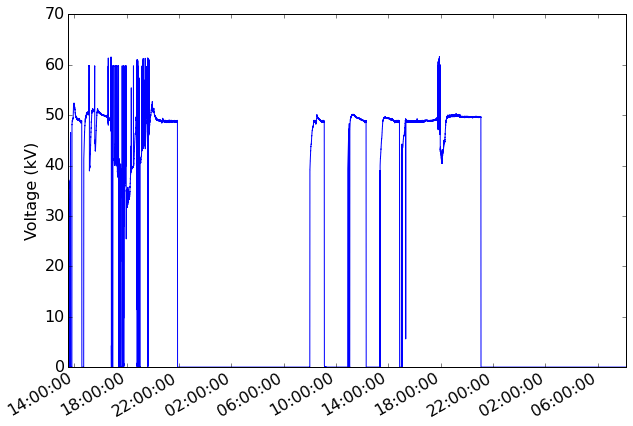

In [25]:
plt.plot(t,data['v'])
plt.gcf().autofmt_xdate()
plt.ylabel("Voltage (kV)")
plt.savefig("voltage_v_time.png")
plt.show()

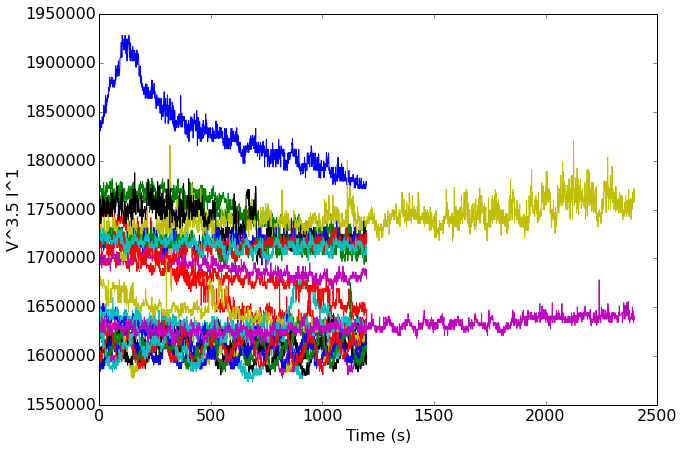

In [26]:
setpoint_v35i1 = 50**(3.5)*2**1
for i, c in enumerate(counts):
    # Take the time range
    sel = (t > c['start']) & (t < c['end'])
    
    # Hack to skip funky measurement
    if i == 2:
        continue
    

    time_since_start = t[sel]
    time_since_start = [(timestamp - t[sel][0]).total_seconds() for timestamp in t[sel]]
    plt.plot(time_since_start,data[sel]['v']**(3.5)*data[sel]['i']**1,label=i)
    corr_factor = (np.average(data[sel]['v']**(3.5)*data[sel]['i']**1)/setpoint_v35i1)
#plt.gcf().autofmt_xdate()
plt.xlabel("Time (s)")
plt.ylabel("V^3.5 I^1")
#plt.legend()
plt.show()

In [27]:
setpoint_v35i1 = 50**(3.5)*2**1

corr_factor = []
# lc_counts_corr = []
# lc_err = []
# lc_err_corr = []

for i, c in enumerate(counts):
    # Take the time range
    sel = (t > c['start']) & (t < c['end'])
    
    time_since_start = t[sel]
    time_since_start = [(timestamp - t[sel][0]).total_seconds() for timestamp in t[sel]]
    corr_factor_entry = 1/(np.average(data[sel]['v']**(3.5)*data[sel]['i']**1)/setpoint_v35i1)
    print("Counts: %d, correction factor: %.5f, corrected counts: %.1f "
          % (c['lc_counts'],corr_factor_entry,corr_factor_entry*c['lc_counts']))
    
    corr_factor.append(corr_factor_entry)
    


Counts: 987, correction factor: 0.96722, corrected counts: 954.6 
Counts: 1064, correction factor: 1.01364, corrected counts: 1078.5 
Counts: 815, correction factor: 1.12583, corrected counts: 917.6 
Counts: 960, correction factor: 1.05958, corrected counts: 1017.2 
Counts: 823, correction factor: 1.08654, corrected counts: 894.2 
Counts: 691, correction factor: 1.09882, corrected counts: 759.3 
Counts: 564, correction factor: 1.09758, corrected counts: 619.0 
Counts: 426, correction factor: 1.09804, corrected counts: 467.8 
Counts: 1024, correction factor: 1.09358, corrected counts: 1119.8 
Counts: 1169, correction factor: 1.01327, corrected counts: 1184.5 
Counts: 1121, correction factor: 1.05343, corrected counts: 1180.9 
Counts: 984, correction factor: 1.08896, corrected counts: 1071.5 
Counts: 967, correction factor: 1.04556, corrected counts: 1011.1 
Counts: 815, correction factor: 1.07600, corrected counts: 876.9 
Counts: 731, correction factor: 1.09852, corrected counts: 803.0 

In [28]:
counts = append_to_array(counts,np.array(corr_factor),'corr_factor')
counts = append_to_array(counts,counts['corr_factor'] * counts['lc_counts'],'lc_counts_corr')
counts = append_to_array(counts, np.sqrt(counts['lc_counts']) * counts['corr_factor'], 'lc_err_corr')
counts = append_to_array(counts, counts['lc_counts_corr'] / counts['interval'], 'lc_cps_corr' )
counts = append_to_array(counts, counts['lc_err_corr'] / counts['interval'], 'lc_cps_err_corr')

In [29]:
angles = np.array([0,10,20,30,40,50,60,70,0,0,-10,-20,-30,-40,-50,-60,0,10,20,80,90,30,40,50,60,70], dtype=float)
assert(len(angles) == len(counts))
counts = append_to_array(counts, angles, 'angle')

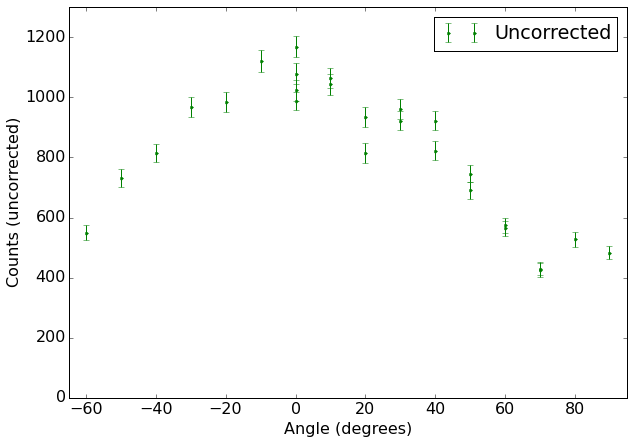

In [30]:
plt.errorbar(counts['angle'], counts['lc_counts'], yerr=counts['lc_err_corr'],ls='None', 
             marker='.',color='green',label='Uncorrected')
plt.xlabel("Angle (degrees)")
plt.ylabel("Counts (uncorrected)")
plt.ylim(0,1300)
plt.xlim(-65,95)
plt.legend()
plt.show()

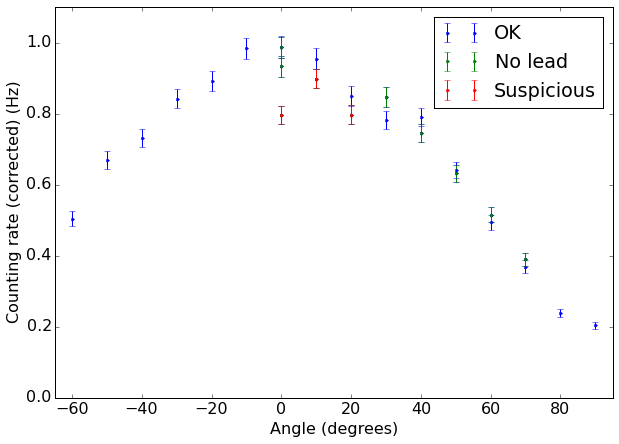

In [32]:

plt.errorbar(counts['angle'],counts['lc_cps_corr'],yerr=counts['lc_cps_err_corr'], ls='None', marker='.',label='OK')
plt.errorbar(counts[0:10]['angle'],counts[0:10]['lc_cps_corr'],yerr=counts[0:10]['lc_cps_err_corr'], ls='None', 
             marker='.',color='green',label='No lead')
plt.errorbar(counts[0:3]['angle'],counts[0:3]['lc_cps_corr'],yerr=counts[0:3]['lc_cps_err_corr'], ls='None', 
             marker='.',color='red',label='Suspicious')
plt.xlabel("Angle (degrees)")
plt.ylabel("Counting rate (corrected) (Hz)")
plt.ylim(0,1.1)
plt.xlim(-65,95)
plt.legend()
plt.show()